In [8]:
import numpy as np
import scipy
import scipy.sparse as sparse
import copy
import random
import time
import scipy.optimize as opt
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm 

In [9]:
import ssnmf
del ssnmf
import ssnmf
from ssnmf import SSNMF


In [10]:
### To do:
#Semi log plot of the errors
#Plot error average over multiple run
#Plot yhat every (other) iteration

#######DONE##########

##FIX ACCURACY  line 700???

## everytime we update c, we want to rescale c so that the columns add to 1?
## and then we use the scale that we used on c (a diag mx.), invert it (i.e. 100 -> 1/100) and multiply S with it.



In [ ]:
"""
Model description as of now:
7. ||X-AS||^2 +||Y-YCS||^2 No missing indicator
    dictupdateCFro
    repupdateYConvexFF

8. ||X-AS||^2 +||Y-YCS||^2 With missing indicator
    dictupdateCFroMiss
    repupdateYConvexFFMiss

9. ||X-AS||^2 +||Y-YCS||^2 Allow negative entries
    dictupdateCFroNeg
    repupdateYConvexFFNeg

10. ||X-AS||^2 +||Y-YCS||^2 Squareroot update (no negative entries)
    dictupdateCFroSq
    repupdateYConvexFFsq

11. ||X-XCS||^2 +||Y-BS||^2 
    repupdateXConvexFF

12. ||X-XCS||^2 +||Y-YCS||^2 
    dictupdateCFroBoth
    repupdateBothConvexFF
"""

### Test scaling function

In [11]:
def scalingC(unscaledC):
    #if C is nxm
    #make diag mx of mxm
    cols = np.shape(unscaledC)[1]
    scaling = np.zeros((cols, cols))

    invScalingArr = unscaledC.sum(axis=0)
    scalingArr = 1./invScalingArr
    
    np.fill_diagonal(scaling, scalingArr)
    C = unscaledC @ scaling
    
    np.fill_diagonal(scaling,invScalingArr)
    return C, scaling

In [12]:
S_c = np.random.rand(10,40)
C_c = np.random.rand(40,10)

C_c_scaled, scaling = scalingC(C_c)
Z = C_c @ S_c
Z_scaled = C_c_scaled @ scaling @ S_c
#Z

array([[3.65644587, 2.81681337, 2.92474386, ..., 2.33838104, 3.04116438,
        2.57670301],
       [3.66214523, 2.10199895, 2.76140863, ..., 1.81056601, 2.31883497,
        2.56179562],
       [2.28505716, 1.51148058, 1.87848037, ..., 1.63813283, 1.58557075,
        1.80781759],
       ...,
       [3.66139205, 2.42616593, 2.6899251 , ..., 1.77663056, 2.48408254,
        2.61182594],
       [2.8234669 , 1.6747671 , 1.99398707, ..., 1.42978783, 1.71181381,
        1.85016842],
       [2.81750594, 1.88087677, 2.28170602, ..., 1.97273452, 2.19745079,
        2.21584986]])

In [13]:
#Z_scaled

array([[3.65644587, 2.81681337, 2.92474386, ..., 2.33838104, 3.04116438,
        2.57670301],
       [3.66214523, 2.10199895, 2.76140863, ..., 1.81056601, 2.31883497,
        2.56179562],
       [2.28505716, 1.51148058, 1.87848037, ..., 1.63813283, 1.58557075,
        1.80781759],
       ...,
       [3.66139205, 2.42616593, 2.6899251 , ..., 1.77663056, 2.48408254,
        2.61182594],
       [2.8234669 , 1.6747671 , 1.99398707, ..., 1.42978783, 1.71181381,
        1.85016842],
       [2.81750594, 1.88087677, 2.28170602, ..., 1.97273452, 2.19745079,
        2.21584986]])

# Initializing 

In [16]:
labelmat_c = np.concatenate((np.concatenate((np.ones([1,10]),np.zeros([1,30])),axis=1),
                           np.concatenate((np.zeros([1,10]),np.ones([1,10]),np.zeros([1,20])),axis=1),
                           np.concatenate((np.zeros([1,20]),np.ones([1,10]),np.zeros([1,10])),axis=1),
                           np.concatenate((np.zeros([1,30]),np.ones([1,10])),axis=1)))

S_c = np.random.rand(10,40)
I_c = np.zeros((40, 40), int)
np.fill_diagonal(I_c, 1)

C_c = np.zeros([40,10])
for i in range(40):
    C_c[i,:] = opt.nnls(np.transpose(S_c),I_c[:,i])[0]
    
C_c, scaling = scalingC(C_c)
S_c = scaling @ S_c

###
A_c = np.random.rand(40,10)
I_c = np.zeros((10, 10))
np.fill_diagonal(I_c, 0.25) ###scaling norm of X
A_c = A_c @ I_c
###

X_c = A_c @ S_c



#scaling A_c to match with labelmat_c
#labelmat_norm = np.linalg.norm(labelmat_c, 'fro')
#X_norm = np.linalg.norm(X_c,'fro')


In [17]:
np.linalg.norm(labelmat_c, 'fro')

6.324555320336759

In [18]:
np.linalg.norm(X_c, 'fro')

7.952498073192491

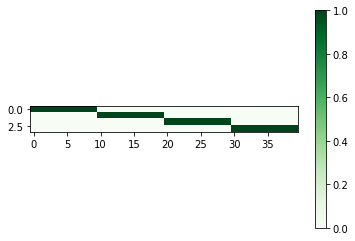

In [19]:
#z_min, z_max = -np.abs(labelmat).max(), np.abs(labelmat).max() 
a = plt.imshow(labelmat_c, cmap ='Greens') 
plt.colorbar(a) 

plt.show() 

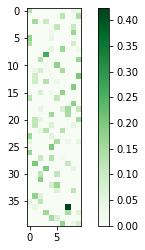

In [20]:
b = plt.imshow(C_c, cmap ='Greens') 
plt.colorbar(b) 

plt.show() 

In [21]:
#check nonnegativity of C_c
print(np.min(C_c))
print(np.min(labelmat_c @ C_c))

0.0
0.0


## Train

In [22]:
allModelNum = [7,8,9,10]

Model Number:7
the initial relative reconstruction error is  82932438.96117997
the initial classifier's accuracy is  0.275
number of iterations that this model runs:  39
the final relative reconstruction error is  0.01129867558399001
the final classifier's accuracy is  0.75


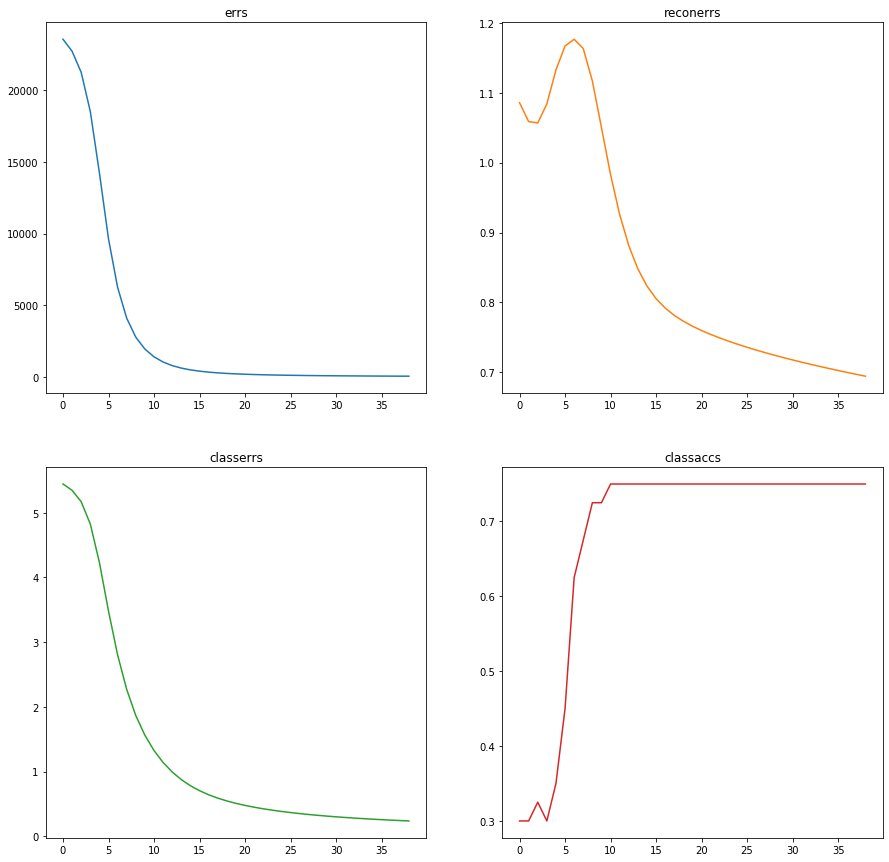

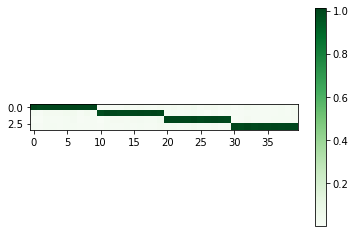

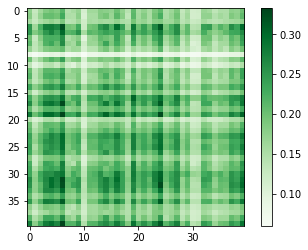

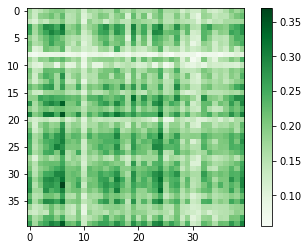

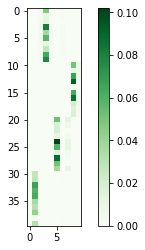

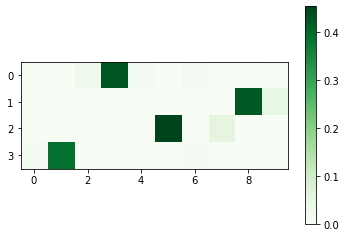

Model Number:8
the initial relative reconstruction error is  79827167.12562037
the initial classifier's accuracy is  0.275
number of iterations that this model runs:  40
the final relative reconstruction error is  0.010086722291573142
the final classifier's accuracy is  0.475


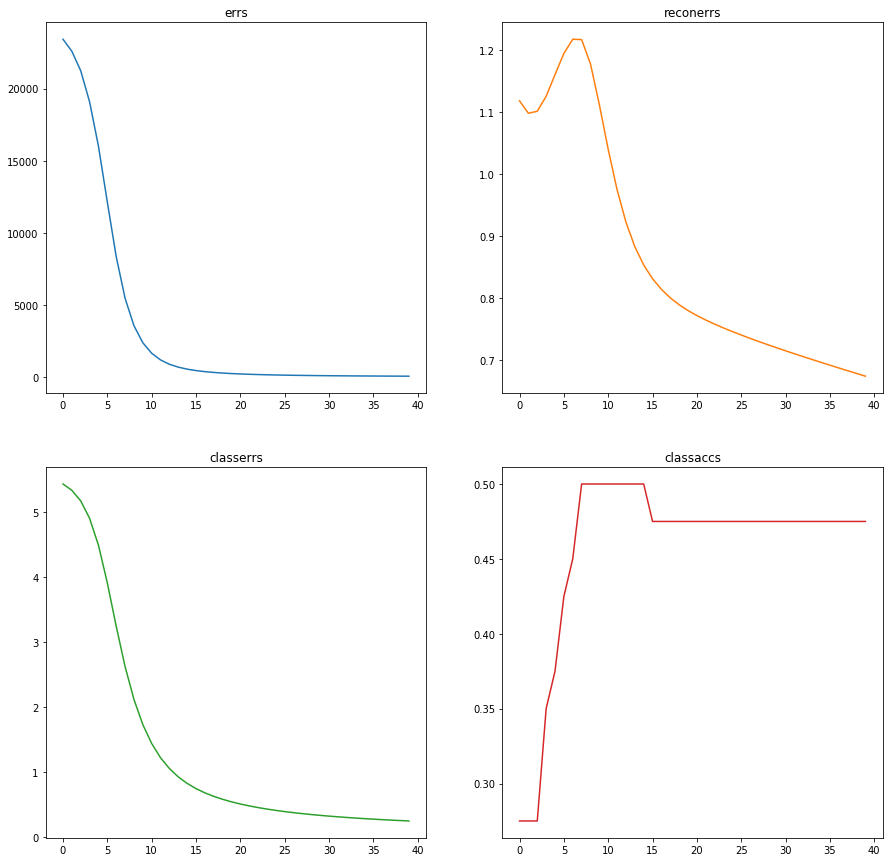

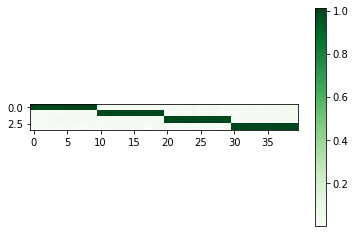

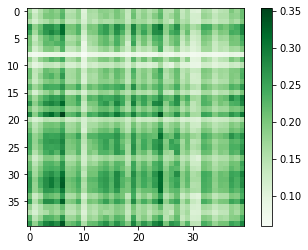

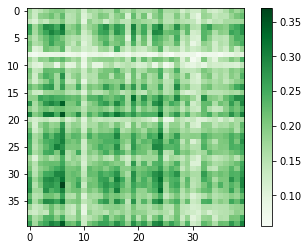

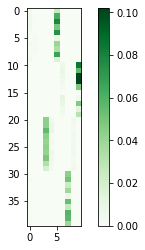

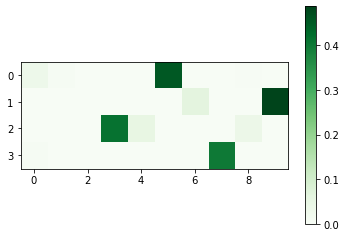

Model Number:9
the initial relative reconstruction error is  77112305.61936042
the initial classifier's accuracy is  0.225
number of iterations that this model runs:  48
the final relative reconstruction error is  0.0028756206536006395
the final classifier's accuracy is  0.0


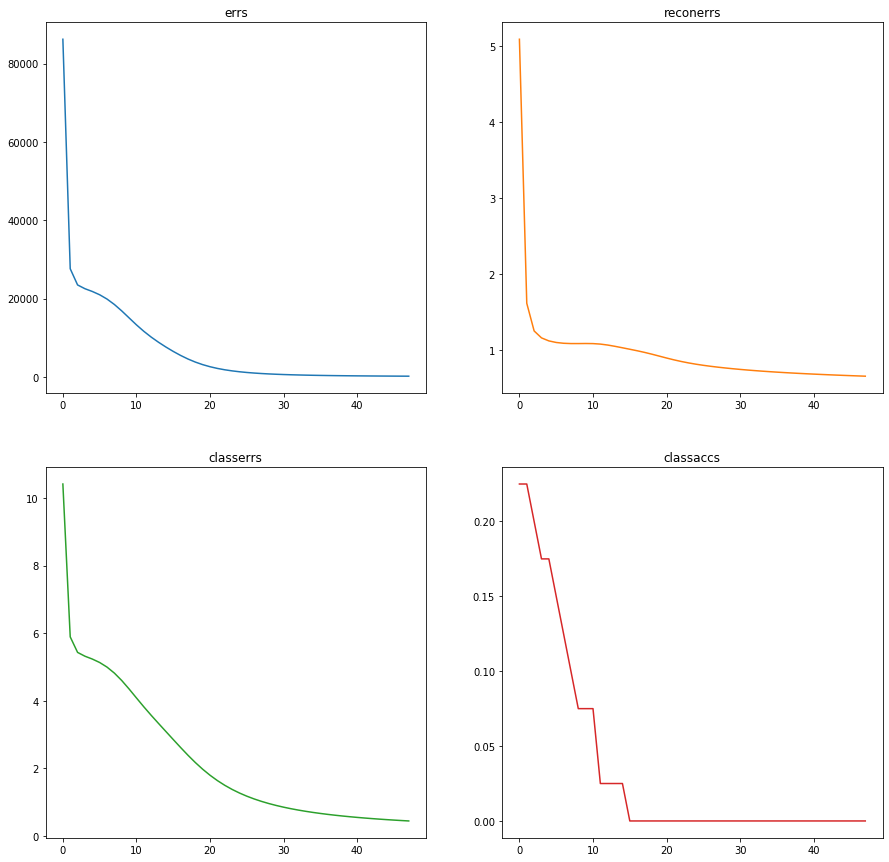

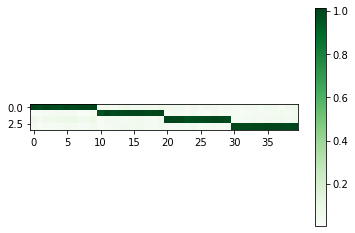

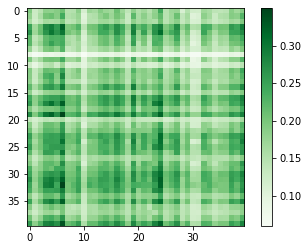

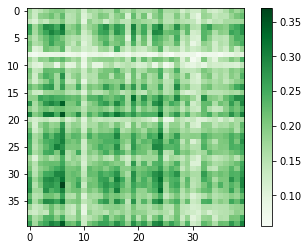

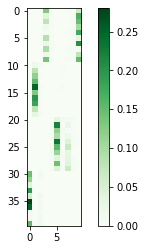

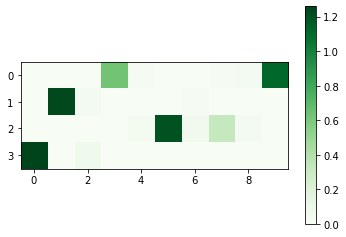

Model Number:10
the initial relative reconstruction error is  66745182.30082375
the initial classifier's accuracy is  0.25
number of iterations that this model runs:  43
the final relative reconstruction error is  0.009358026515776064
the final classifier's accuracy is  0.15


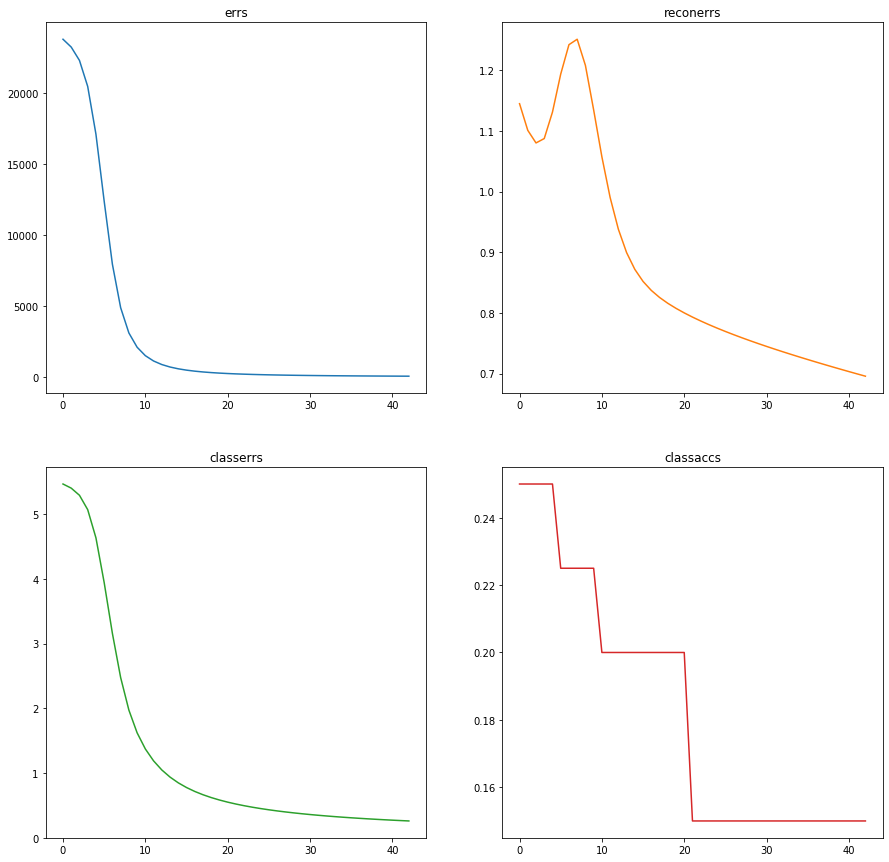

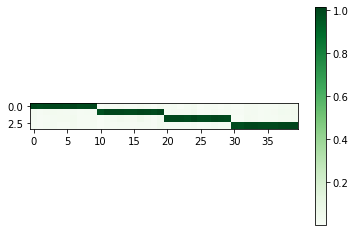

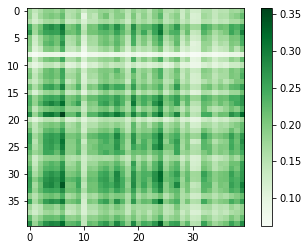

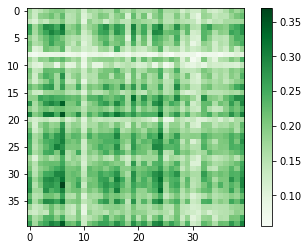

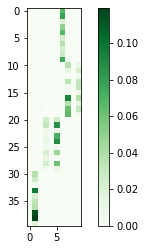

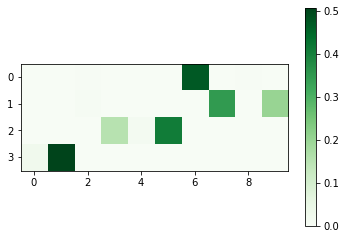

In [23]:
for modelNum in allModelNum:
    print('Model Number:' + str(modelNum))
    k = 10
    model = SSNMF(X_c,k,Y = labelmat_c,lam=100*np.linalg.norm(X_c,'fro'),modelNum=modelNum)
    ini_error = model.fronorm(model.X, model.A, model.S, model.W)**2 + model.lam * model.fronorm_c(model.Y, model.C, model.S, model.L)**2

    #initial accuracy
    acc = model.accuracy()
    print("the initial relative reconstruction error is ", ini_error)
    print("the initial classifier's accuracy is ", acc)


    #final reconstruction error
    N = 10000
    [errs,reconerrs,classerrs,classaccs] = model.mult(numiters = N,saveerrs = True)
    size = reconerrs.shape[0]
    rel_error = reconerrs[size - 1]**2/(model.fronorm(model.X, model.A, model.S, model.W)**2 + model.lam * model.fronorm_c(model.Y, model.C, model.S, model.L)**2)
    acc = classaccs[size - 1]
    print("number of iterations that this model runs: ", size)
    print("the final relative reconstruction error is ", rel_error)
    print("the final classifier's accuracy is ", acc)

    #plot accuracy
    fig, axs = plt.subplots(2, 2,figsize=(15,15))
    axs[0, 0].plot(range(0,size), errs)
    axs[0, 0].set_title('errs')
    axs[0, 1].plot(range(0,size), reconerrs, 'tab:orange')
    axs[0, 1].set_title('reconerrs')
    axs[1, 0].plot(range(0,size), classerrs, 'tab:green')
    axs[1, 0].set_title('classerrs')
    axs[1, 1].plot(range(0,size), classaccs, 'tab:red')
    axs[1, 1].set_title('classaccs')

    plt.figure()  
    d = plt.imshow(model.Y @ model.C @ model.S,cmap = 'Greens')
    plt.colorbar(d) 
    plt.show() 

    e = plt.imshow(model.A @ model.S,cmap = 'Greens')
    plt.colorbar(e)
    plt.show()

    f = plt.imshow(X_c,cmap = 'Greens')
    plt.colorbar(f)
    plt.show()

    g = plt.imshow(model.C,cmap = 'Greens')
    plt.colorbar(g)
    plt.show()

    h = plt.imshow(model.Y @ model.C,cmap = 'Greens')
    plt.colorbar(h)
    plt.show()

### Constrain convexity on X -> X=XCS, Y=BS. (Model 11)

In [24]:
X_c = np.random.rand(40,40)
S_c = np.random.rand(10,40)
I_c = np.zeros((40, 40), int)
np.fill_diagonal(I_c, 1)

C_c = np.zeros([40,10])
for i in range(40):
    C_c[i,:] = opt.nnls(np.transpose(S_c),I_c[:,i])[0]
    
C_c, scaling = scalingC(C_c)
S_c = scaling @ S_c

###
B_c = np.random.rand(40,10)
I_c = np.zeros((10, 10))
np.fill_diagonal(I_c, 0.25) ####scaling norm of Y
B_c = B_c @ I_c
###

labelmat_c = B_c @ S_c


In [25]:
np.linalg.norm(labelmat_c, 'fro')

7.500744004002741

In [26]:
np.linalg.norm(X_c, 'fro')

23.058558208026028

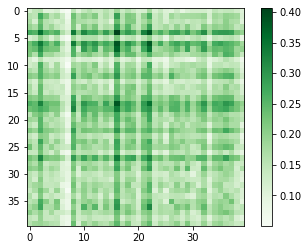

In [27]:
#z_min, z_max = -np.abs(labelmat).max(), np.abs(labelmat).max() 
a = plt.imshow(labelmat_c, cmap ='Greens') 
plt.colorbar(a) 

plt.show() 

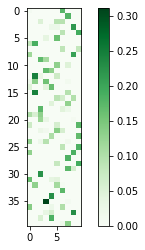

In [28]:
b = plt.imshow(C_c, cmap ='Greens') 
plt.colorbar(b) 

plt.show() 

In [29]:
#check nonnegativity of C_c
print(np.min(C_c))
print(np.min(labelmat_c @ C_c))

0.0
0.09767737347001411


Model Number:11
the initial relative reconstruction error is  1356479213.027281
the initial classifier's accuracy is  0.0
number of iterations that this model runs:  80
the final relative reconstruction error is  0.00798220862932432
the final classifier's accuracy is  0.525


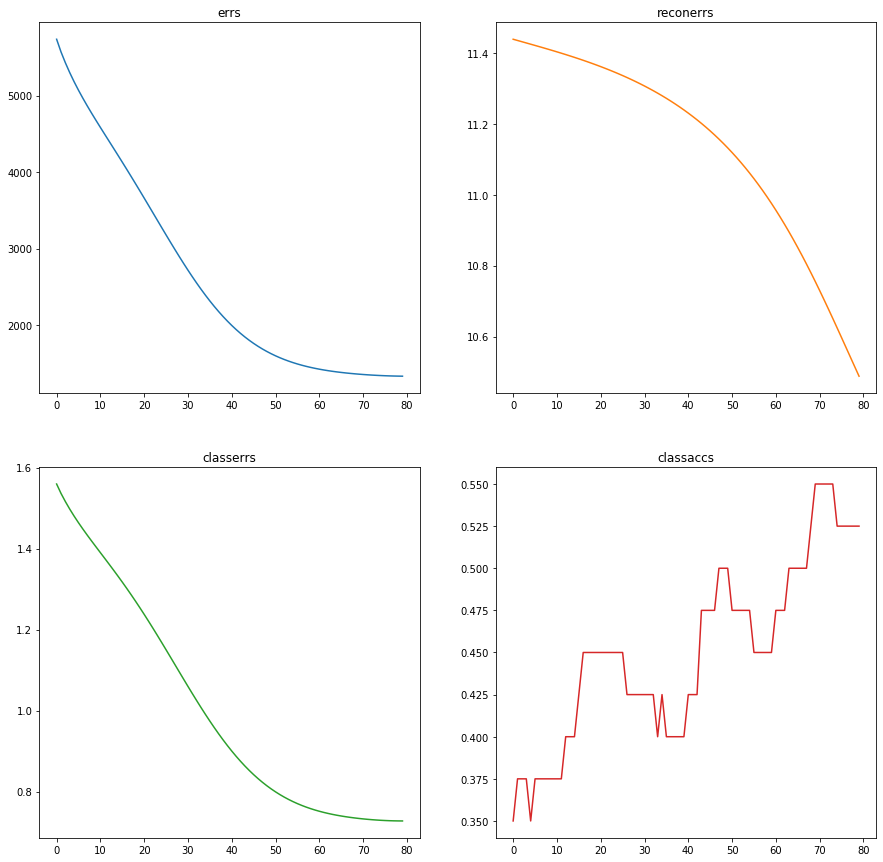

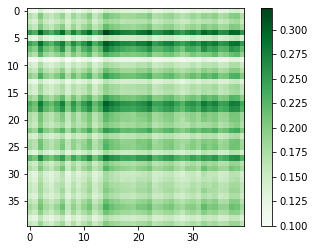

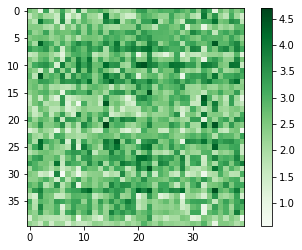

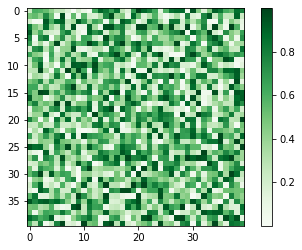

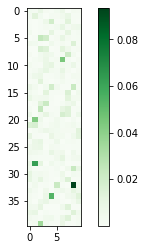

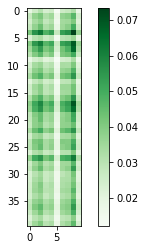

In [30]:
modelNum = 11
print('Model Number:' + str(modelNum))
k = 10
model = SSNMF(X_c,k,Y = labelmat_c,lam=100*np.linalg.norm(X_c,'fro'),modelNum=modelNum)
ini_error = model.fronorm(model.X, model.A, model.S, model.W)**2 + model.lam * model.fronorm_c(model.Y, model.C, model.S, model.L)**2

#initial accuracy
acc = model.accuracy()
print("the initial relative reconstruction error is ", ini_error)
print("the initial classifier's accuracy is ", acc)


#final reconstruction error
N = 10000
[errs,reconerrs,classerrs,classaccs] = model.mult(numiters = N,saveerrs = True)
size = reconerrs.shape[0]
rel_error = reconerrs[size - 1]**2/(model.fronorm(model.X, model.A, model.S, model.W)**2 + model.lam * model.fronorm_c(model.Y, model.C, model.S, model.L)**2)
acc = classaccs[size - 1]
print("number of iterations that this model runs: ", size)
print("the final relative reconstruction error is ", rel_error)
print("the final classifier's accuracy is ", acc)

#plot accuracy
fig, axs = plt.subplots(2, 2,figsize=(15,15))
axs[0, 0].plot(range(0,size), errs)
axs[0, 0].set_title('errs')
axs[0, 1].plot(range(0,size), reconerrs, 'tab:orange')
axs[0, 1].set_title('reconerrs')
axs[1, 0].plot(range(0,size), classerrs, 'tab:green')
axs[1, 0].set_title('classerrs')
axs[1, 1].plot(range(0,size), classaccs, 'tab:red')
axs[1, 1].set_title('classaccs')

plt.figure()  
d = plt.imshow(model.Y @ model.C @ model.S,cmap = 'Greens')
plt.colorbar(d) 
plt.show() 

e = plt.imshow(model.A @ model.S,cmap = 'Greens')
plt.colorbar(e)
plt.show()

f = plt.imshow(X_c,cmap = 'Greens')
plt.colorbar(f)
plt.show()

g = plt.imshow(model.C,cmap = 'Greens')
plt.colorbar(g)
plt.show()

h = plt.imshow(model.Y @ model.C,cmap = 'Greens')
plt.colorbar(h)
plt.show()

# Compare to normal FF

In [31]:
model2 = SSNMF(X_c,k,Y = labelmat_c,lam=100*np.linalg.norm(X_c,'fro'), modelNum = 3)

In [32]:
ini_error_ = model2.fronorm(model2.X, model2.A, model2.S, model2.W)**2 + model2.lam * model2.fronorm(model2.Y, model2.B, model2.S, model2.L)**2
acc_ = model2.accuracy()
print("the initial relative reconstruction error is ", ini_error_)
print("the initial classifier's accuracy is ", acc_)

the initial relative reconstruction error is  22897217.666004937
the initial classifier's accuracy is  0.025


In [33]:
N = 10000
[errs_,reconerrs_,classerrs_,classaccs_] = model2.mult(numiters = N,saveerrs = True)

In [34]:
size = reconerrs_.shape[0]
rel_error_ = reconerrs_[size - 1]**2/(model2.fronorm(model2.X, model2.A, model2.S, model2.W)**2 + model2.lam * model2.fronorm(model2.Y, model2.B, model2.S, model2.L)**2)
acc_ = classaccs_[size - 1]
print("number of iterations that this model runs: ", size)
print("the final relative reconstruction error is ", rel_error_)
print("the final classifier's accuracy is ", acc_)

number of iterations that this model runs:  282
the final relative reconstruction error is  0.7014620891523476
the final classifier's accuracy is  0.85


Text(0.5, 1.0, 'classaccs')

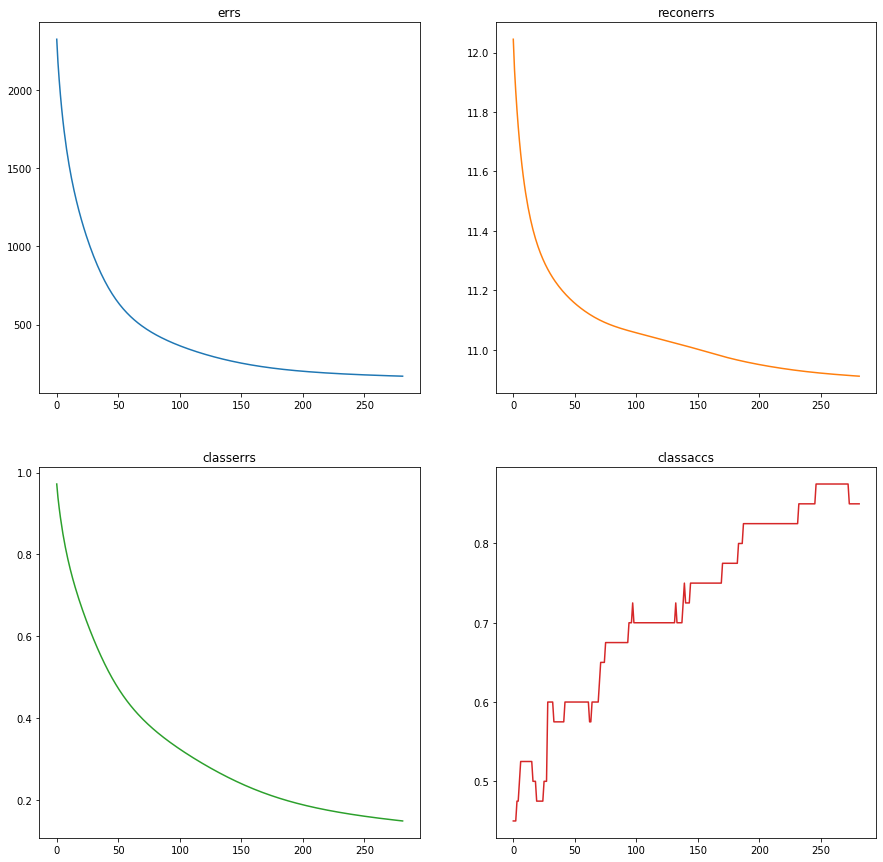

In [35]:
fig, axs = plt.subplots(2, 2,figsize=(15,15))
axs[0, 0].plot(range(0,size), errs_)
axs[0, 0].set_title('errs')
axs[0, 1].plot(range(0,size), reconerrs_, 'tab:orange')
axs[0, 1].set_title('reconerrs')
axs[1, 0].plot(range(0,size), classerrs_, 'tab:green')
axs[1, 0].set_title('classerrs')
axs[1, 1].plot(range(0,size), classaccs_, 'tab:red')
axs[1, 1].set_title('classaccs')